In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from torchsummaryX import summary

# Check to see if your system has gpu (for Macbooks using Apple silicon)
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")
print(mps_device) # prints True if gpu is available, else False

print("Device:", mps_device)
print("PyTorch version:", torch.__version__)

tensor([1.], device='mps:0')
mps
Device: mps
PyTorch version: 2.5.1


In [2]:
class XORDataset(torch.utils.data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

dataset = XORDataset(200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([ 0.1067, -0.0942]), tensor(0))


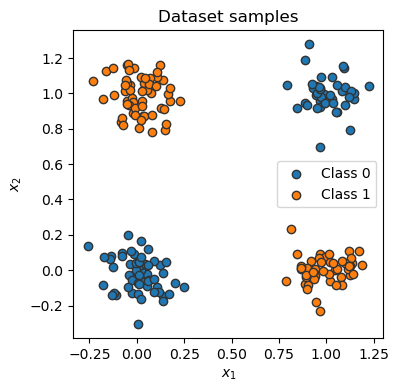

In [3]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

visualize_samples(dataset.data, dataset.label)
plt.show()

In [4]:
data_loader = torch.utils.data.DataLoader(
    dataset = dataset, # dataset from which to load the data.
    batch_size = 8, # how many samples per batch to load (default: 1).
    shuffle = True, # set to True to have the data reshuffled at every epoch (default: False).
    num_workers = 0, # how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)
    pin_memory = True, # If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them.
    drop_last = False # set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)
    )

# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.0229,  1.0925],
        [ 0.9675,  0.9573],
        [ 0.0788,  0.7790],
        [ 1.0149,  0.0941],
        [ 1.0573,  0.8954],
        [ 0.9810, -0.0034],
        [ 1.0534,  0.0060],
        [ 0.1078,  1.0931]])
Data labels torch.Size([8]) 
 tensor([1, 0, 1, 1, 0, 1, 1, 1])


In [5]:
class XORClassifier(torch.nn.Module):

    def __init__(self):
        super(XORClassifier, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(
                in_features   = 2     , # size of each input sample
                out_features  = 2     , # size of each output sample
                bias          = True  ), # If set to False, the layer will not learn an additive bias. Default: True
            torch.nn.Tanh(),
            torch.nn.Linear(2, 1)
        )

    def forward(self, x):
        out = self.model(x)
        return out

model = XORClassifier().to(mps_device)

In [6]:
print(model)

XORClassifier(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Tanh()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)


In [7]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter model.0.weight, shape torch.Size([2, 2])
Parameter model.0.bias, shape torch.Size([2])
Parameter model.2.weight, shape torch.Size([1, 2])
Parameter model.2.bias, shape torch.Size([1])


In [8]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, {param}\n")

Parameter model.0.weight, Parameter containing:
tensor([[ 0.1853, -0.4114],
        [-0.0563, -0.3288]], device='mps:0', requires_grad=True)

Parameter model.0.bias, Parameter containing:
tensor([-0.2984,  0.0580], device='mps:0', requires_grad=True)

Parameter model.2.weight, Parameter containing:
tensor([[-0.4361, -0.2099]], device='mps:0', requires_grad=True)

Parameter model.2.bias, Parameter containing:
tensor([-0.3829], device='mps:0', requires_grad=True)



In [10]:
from torchinfo import summary

summary(model, input_size=(8, 2))


Layer (type:depth-idx)                   Output Shape              Param #
XORClassifier                            [8, 1]                    --
├─Sequential: 1-1                        [8, 1]                    --
│    └─Linear: 2-1                       [8, 2]                    6
│    └─Tanh: 2-2                         [8, 2]                    --
│    └─Linear: 2-3                       [8, 1]                    3
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00